# INIZIALIZZAZIONI

In [1]:
!pip install datetime numpy matplotlib tqdm pillow scikit-image pydicom opencv-python scikit-learn keras torch torchvision scipy pytz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 15.4 MB/s eta 0:00:00


In [2]:
import os
import glob
import random
import copy
import pickle
from google.colab import drive

from datetime import datetime
import pytz

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import csv

import PIL
from skimage import io, color, transform
from scipy.ndimage import zoom

import pydicom

import cv2

from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import KFold
import sklearn.metrics
#in particolare f1 score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
#torchvision.transforms contiene ToTensor

from torchvision import datasets, transforms

In [3]:
%pwd

'/content'

In [4]:
!ls | grep '^d'


drive


In [5]:
drive.mount('drive', force_remount=True) #'drive' è il nome della cartella che assegno al drive montato. una volta montato risiederà in content

Mounted at drive


In [6]:
print(os.getcwd())
subdirectories = [d for d in os.listdir(os.getcwd()) if os.path.isdir(os.path.join(os.getcwd(), d))]
print(subdirectories)

/content
['.config', 'drive', 'sample_data']


In [7]:
os.chdir("/content/drive/MyDrive/CHAOS")

In [ ]:
#os.chdir("/content")

# PARAMETRI

In [9]:
IMG_DIR = "train"

patients_for_training = ["01","02","03","05","08","10","13","15","19","20","21","22","31","32","33","34","36","37","38","39"]
patients_for_testing = ["04","06","07","09","11","12","14","16","17","18","23","24","25","26","27","28","29","30","35","40"]

label_map = ["background", "liver", "right kidney", "left kidney", "spleen"]

TARGET_INFORMATION_DENSITY = (1, 1)
TARGET_RESOLUTION = (256, 256)

In [10]:
def get_current_date():
  current_time_utc = datetime.utcnow()

  desired_timezone = pytz.timezone('Europe/Rome')

  # Convert the UTC time to the desired timezone
  current_time_local = current_time_utc.replace(tzinfo=pytz.utc).astimezone(desired_timezone)

  formatted_date = current_time_local.strftime("%Y-%m-%d_%H-%M-%S")

  return formatted_date

# Train/Eval split
il training loop nella versione attuale non ne fa uso, dato che utilizza kfold

In [ ]:
# --- EXECUTION FLOW ---

#non più necessario grazie a implementazionoe di kfold

# eval_patients = eval_split()
"""
restituisce un set, i cui elementi (un numero dipendente dalla percentuale
di split) sono scelti randomicamente. lo uso per controllare se sono in un
paziente training, o in un paziente eval
"""
# print(eval_patients)

In [ ]:
def eval_split():
    eval_sample_size = int(len(patients_for_training) * EVAL_SPLIT_PERCENTAGE)
    random_eval_sample = set(random.sample(patients_for_training, eval_sample_size))
    return random_eval_sample

# FETCHING DI DIRECTORY DELLE IMMAGINI

NOTA: il dataset è nel file system è stato riorganizzato in una directory a due livelli:
> (directory): *numero_paziente*
>> (filename): *mode*_*codice*.*formato*

quindi il contenuto in una cartella paziente, se visualizzato in ordine alfabetico, apparirà di questo tipo:
*   T1DUAL-*codice_dispari*.dcm (outphase)
*   T1DUAL-*codice_pari*.dcm (inphase)
*   T1DUAL-*codicepari*.png (mask, avente lo stesso codice della inphase)
*   (...)
*   T2SPIR-codice.dcm
*   T2SPIR-codice.png
*   (...)




# IMPORTAZIONE, PREPROCESSING, STRUTTURE DATI

In [14]:
imgs_collection = imgs_collections()
imgs_collection.create_collection()
imgs_collection.process_collection()

Output streaming troncato alle ultime 5000 righe.
caricato 752/1917
caricato 753/1917
caricato 754/1917
caricato 755/1917
caricato 756/1917
caricato 757/1917
caricato 758/1917
caricato 759/1917
caricato 760/1917
caricato 761/1917
caricato 762/1917
caricato 763/1917
caricato 764/1917
caricato 765/1917
caricato 766/1917
caricato 767/1917
caricato 768/1917
caricato 769/1917
caricato 770/1917
caricato 771/1917
caricato 772/1917
caricato 773/1917
caricato 774/1917
caricato 775/1917
caricato 776/1917
caricato 777/1917
caricato 778/1917
caricato 779/1917
caricato 780/1917
caricato 781/1917
caricato 782/1917
caricato 783/1917
caricato 784/1917
caricato 785/1917
caricato 786/1917
caricato 787/1917
caricato 788/1917
caricato 789/1917
caricato 790/1917
caricato 791/1917
caricato 792/1917
caricato 793/1917
caricato 794/1917
caricato 795/1917
caricato 796/1917
caricato 797/1917
caricato 798/1917
caricato 799/1917
caricato 800/1917
caricato 801/1917
caricato 802/1917
caricato 803/1917
caricato 804/1

(256, 256)


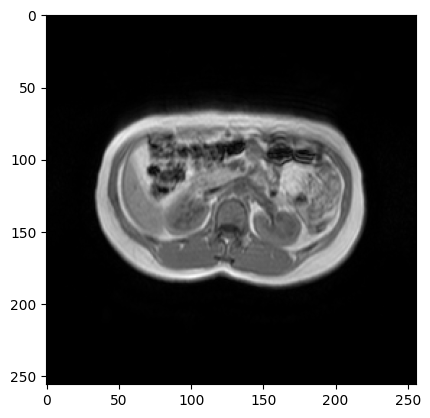

In [ ]:
print(imgs_collection.imgs[1770].img.shape)
imgs_collection.imgs[1770].show_img()

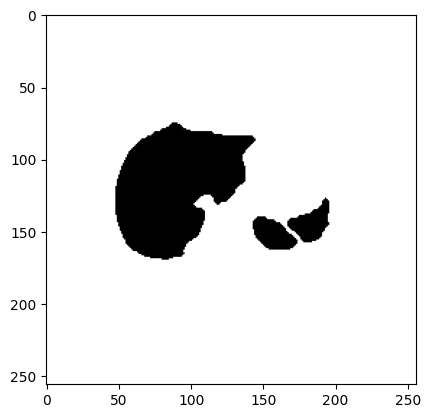

In [ ]:
plt.imshow(imgs_collection.imgs[60].msk_dcmp[0], cmap="gray")

immagine prova - prima: (256, 256)


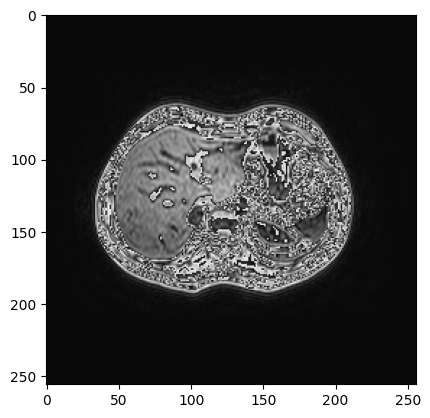

In [66]:
img_prova1 = copy.deepcopy(imgs_collection.imgs[60])
print(f"immagine prova - prima: {img_prova1.img.shape}")
img_prova1.show_img()

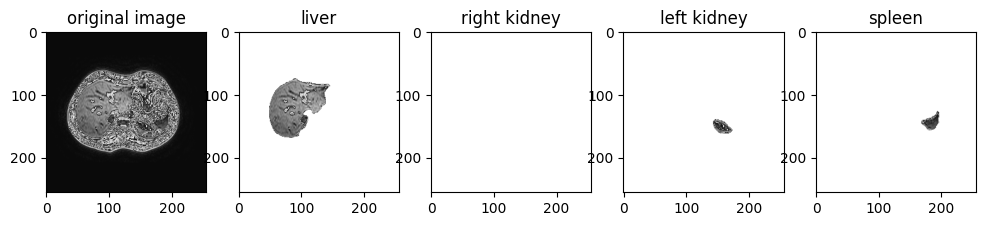

In [67]:
#- []: VERSIONE 1:: SINGOLA


# Assuming you have the original image and segmentation masks
original_image = img_prova1.img
segmentation_masks = img_prova1.msk_dcmp[1:5]  # Channels 1 to 4


def show_img_and_labels(original_image, segmentation_masks):
  fig, axes = plt.subplots(1, len(segmentation_masks) + 1, figsize=(12, 4))

  #plot the original image in the first subplot
  axes[0].imshow(original_image, cmap='gray')
  axes[0].set_title('original image')


  #overlay each segmentation mask in the subsequent subplots
  for i, segmentation_mask in enumerate(segmentation_masks):
      rgba_image = np.zeros(original_image.shape + (2,))
      rgba_image[:, :, 0] = original_image
      rgba_image[:, :, 1] = (segmentation_mask != 0).astype(float)

      #display the overlay
      axes[i + 1].imshow(rgba_image[:, :, 0], cmap='gray', alpha=rgba_image[:, :, 1])
      axes[i + 1].set_title(f'{label_map[i + 1]}')

  plt.show()

show_img_and_labels(original_image, segmentation_masks)

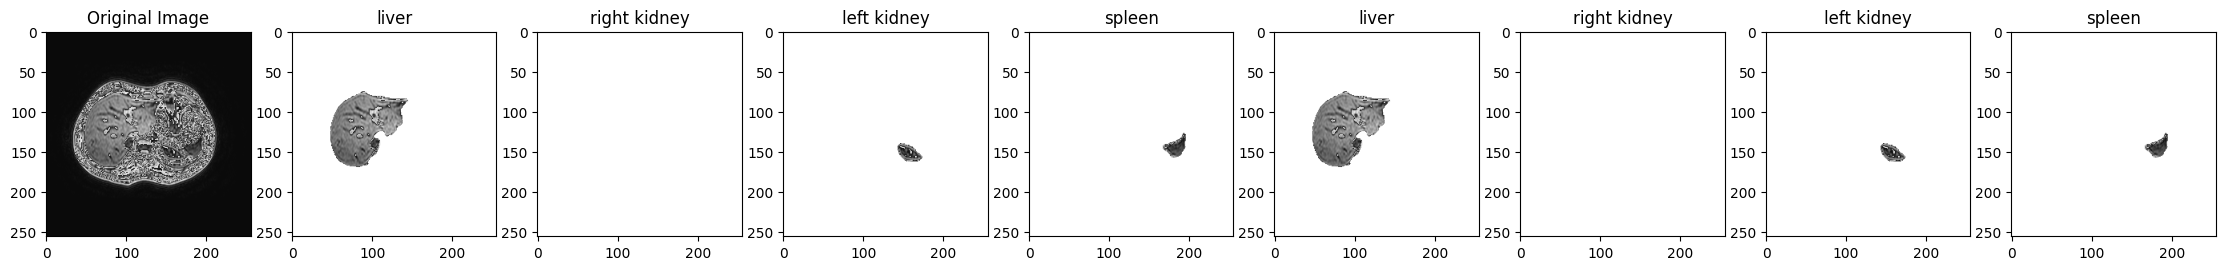

In [69]:
#- []: VERSIONE 2:: DOPPIA


# Assuming you have the original image and segmentation masks
original_image = img_prova1.img
segmentation_masks = img_prova1.msk_dcmp[1:5]  # Channels 1 to 4


def show_img_and_labels(original_image, segmentation_masks, segmentation_masks_two=None):
    num_subplots = len(segmentation_masks) + 1
    if segmentation_masks_two.any():
        num_subplots += len(segmentation_masks_two)

    fig, axes = plt.subplots(1, num_subplots, figsize=(28, 14))

    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')

    if segmentation_masks.any(): #(questo if è solo per far noteare la simmetria di questo blocco di codice con quello successivo. funzionalmente però, segmentation_masks è sempre presente)
      for i, segmentation_mask in enumerate(segmentation_masks):
          rgba_image = np.zeros(original_image.shape + (2,))
          rgba_image[:, :, 0] = original_image
          rgba_image[:, :, 1] = (segmentation_mask != 0).astype(float)

          #mostra l'overlay
          axes[i + 1].imshow(rgba_image[:, :, 0], cmap='gray', alpha=rgba_image[:, :, 1])
          axes[i + 1].set_title(f'{label_map[i + 1]}')

    #overlay each additional segmentation mask if provided
    if segmentation_masks_two.any():
        for i, segmentation_mask_two in enumerate(segmentation_masks_two):
            rgba_image_two = np.zeros(original_image.shape + (2,))
            rgba_image_two[:, :, 0] = original_image
            rgba_image_two[:, :, 1] = (segmentation_mask_two != 0).astype(float)

            #display the overlay for the second set of masks
            axes[len(segmentation_masks) + i + 1].imshow(rgba_image_two[:, :, 0], cmap='gray', alpha=rgba_image_two[:, :, 1])
            axes[len(segmentation_masks) + i + 1].set_title(f'{label_map[i + 1]}')

    plt.show()



show_img_and_labels(original_image=original_image, segmentation_masks=segmentation_masks, segmentation_masks_two=segmentation_masks)

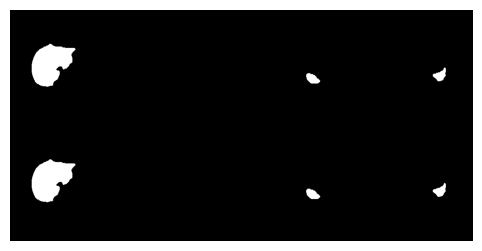

In [68]:
original_image = copy.deepcopy(img_prova1.img)
segmentation_masks = copy.deepcopy(img_prova1.msk_dcmp[0:5])  # Channels 1 to 4


#FUNZIONE UTILE PER CONFRONTARE GROUND TRUTH E OUTPUT (da inserire in classe del modello, e chiamata da funzione che fa inferenze indipendentemente da training loop, chiamata da utente)
def prova(img_array1, img_array2):

  #estraggo le ultime 4 immagini da ciascun array (il background è interessante solo relativamente)
  last_4_images_array1 = img_array1[-4:]
  last_4_images_array2 = img_array2[-4:]

  #concateno le immagini lungo la larghezza (axis=2)
  result_image = np.hstack([last_4_images_array1, last_4_images_array2]) #-> (4, 512, 256)

  #print(result_image.shape)

  #ripeto, ad ottenere (1, 512, 1024)
  stacked_images = np.hstack(result_image)

  fig, axes = plt.subplots(1, 1, figsize=(12, 3))

  #mostro immagine risultante
  axes.imshow(stacked_images, cmap='gray')
  axes.axis('off')

  plt.show()
  """ https://medium.com/analytics-vidhya/numpy-join-and-split-c090b765fa37 """


prova(img_array1=segmentation_masks, img_array2=segmentation_masks)





# classi immagini

classe img_collections contiene una lista di oggetti img_struct, definita piu sotto

In [12]:
class imgs_collections():
  def __init__(self):
    self.imgs = []

  """ EXECUTION FLOW """

  """ 1. CREA COLLEZIONE """
  def create_collection(self):
    self.__load_directories()
    #for i in range(len(imgs)): print(f'({imgs[i].patient_number}{os.path.basename(imgs[i].dcm_path)}, {os.path.basename(imgs[i].png_path)}')
    self.__import_data_in_memory()

  """ 2. PROCESSING COLLEZIONE """
  def process_collection(self):
    for i in range(len(self.imgs)):
      print(f"processo img {i+1}")
      self.imgs[i].resize_and_reshape()
      #self.imgs[i].preprocessing()
      self.imgs[i].msk_decompose()
      print(f"completato {i+1}/{len(self.imgs)}")



  """ SOTTOPROCEDURE UTILIZZATE """
  def __load_directories(self):

    #- RACCOLGO DIRECTORY FILE .DCM E .PNG
    #- ACCOPPIO OGNI IMMAGINE CON LA PROPRIA LABEL
    dcm_paths, png_paths = self.__fetch_paths_of_data(IMG_DIR)
    coupled_paths = self.__coupling(dcm_paths, png_paths)

    #- ISTANZIO STRUTTURE DATI CUSTOM DI TIPO "IMG"
    #- E LE AGGIUNGO DI VOLTA IN VOLTA ALLA COLLECTION DI IMMAGINI
    for i in range(len(coupled_paths)):
      img = img_struct(dcm_path = coupled_paths[i][0], png_path = coupled_paths[i][1])
      self.imgs.append(img)


  def __fetch_paths_of_data(self, root_path):
    file_paths = []
    dcm_paths = []
    png_paths = []

    #1. RACCOLGO TUTTI FILE E RELATIVE DIRECTORY
    for current_folder_path, subfolders, files in sorted(os.walk(root_path)):
        for filename in sorted(files):
            file_path = os.path.join(current_folder_path, filename)
            file_paths.append(file_path)

    #2. DIFFERENZIO IN BASE A FORMATO: .DCM(immagine) --VS-- .PNG(mask)
    #   E LI AGGIUNGO ALLA RISPETTIVA LISTA
    for file in file_paths:
        if file.endswith(".dcm"):
            dcm_paths.append(file)
        elif file.endswith(".png"):
            png_paths.append(file)

    return dcm_paths, png_paths
    """
    I PATH DEI FILE NEGLI ARRAYLIST RISULTERANNO GIA ORGANIZZATI IN ORDINE ALFABETICO
    per via di:
      - sorted(os.walk)
      - sorted(files)
      - riorganizzazione struttura dataset in file system
    """


  def __coupling(self, dcm_paths, png_paths):
    coupled_paths = []
    i=0
    j=0
    lenght = len(dcm_paths)
    while(i < lenght):
      #ACCOPPIO IMMAGINE CON LA RELATIVA MASK
      coupled_paths.append((dcm_paths[i], png_paths[j]))

      #QUALORA STESSI ACCOPPIANDO T1DUAL, DEVO ASSOCIARE
      #UNA MASK (LA STESSA) ANCHE LA IMG INFASE
      if "T1DUAL" in dcm_paths[i]:
        i+=1
        coupled_paths.append((dcm_paths[i], png_paths[j]))
      i+=1
      j+=1
    return coupled_paths
    """
    DI NUOVO, SFRUTTO ORGANIZZAZIONE DATASET IN FILE SYSTEM
    """

  """ IMPORTO DATASET IN MEMORIA """
  def __import_data_in_memory(self):
    for i in range(len(self.imgs)):
      self.imgs[i].import_data_in_memory()
      print(f"caricato {i+1}/{len(self.imgs)}")

In [13]:
class img_struct ():
  def __init__(self, dcm_path, png_path):

      #PATHS
      self.dcm_path = dcm_path
      self.png_path = png_path

      #METADATA
      self.patient_number = os.path.basename(os.path.dirname(dcm_path))
      self.acquisition_protocol = self.get_acquisition_protocol()
      self.acqusition_phase = self.get_acquisition_phase()

      #DATA
      self.img = np.array([]) #SHAPE (256, 256), VALORI [0, 256]
      self.msk = np.array([])
      self.msk_dcmp = np.array([]) #SHAPE (5, 256, 256), VALORI {0, 1}
      self.pixel_spacing = None

  def show_img(self):
    plt.imshow(self.img, cmap="gray")
  def show_msk(self):
    plt.imshow(self.msk, cmap="gray")

  #- [] TO-DO
  def stampa_entrambe(self, num, labels): #solo img, e i layer non-background
    return

  def preprocessing(self):
    if self.acquisition_protocol == "T1DUAL":
      if self.acquisition_phase == "outphase":
        self.preprocessing_t1_outphase()
      elif self.acquisition_phase == "inphase":
        self.preprocessing_t1_inphase

    elif self.acquisition_protocol == "T2SPIR":
      self.preprocessing_t2()

  def get_acquisition_protocol(self):
    filename = os.path.basename(self.dcm_path)
    if filename.startswith("T1DUAL"): return "T1DUAL"
    elif filename.startswith("T2SPIR"): return "T2SPIR"

  def get_acquisition_phase(self):
    if self.acquisition_protocol == "T2SPIR": return None
    elif self.acquisition_protocol == "T1DUAL":
      filename = os.path.basename(self.dcm_path)
      filename_stripped1 = filename[-9:]
      filename_stripped2 = filename_stripped1[:5]
      acquisition_code_number = int(filename_stripped2)
      if acquisition_code_number%2 == 1: return "outphase"
      else: return "inphase"

  #- [] TO-DO
  def preprocessing_t1_outphase(self):
    return
  def preprocessing_t1_inphase(self):
    return
  def preprocessing_t2(self):
    return


  def import_data_in_memory(self):
    dcm_img = pydicom.dcmread(self.dcm_path)
    img = dcm_img.pixel_array
    self.img = img.astype(np.uint8)

    #print(str(dcm_img))
    self.pixel_spacing = dcm_img.PixelSpacing

    msk = PIL.Image.open(self.png_path)
    self.msk = np.array(msk)

    """
    https://pydicom.github.io/pydicom/stable/old/pydicom_user_guide.html
    You can display the entire dataset by simply printing its string value (attraverso str() o repr())
      un dataset è un iteratore che wrappa un dizionario (che contiene contenuti e metadati dell'immagine nei suoi vari campi)
      puoi accedere agli elementi del dizionario tramite key
    """


  def resize_and_reshape(self):
    x_inf_density = self.pixel_spacing[0]
    y_inf_density = self.pixel_spacing[1]
    x_target_inf_density = TARGET_INFORMATION_DENSITY[0]
    y_target_inf_density = TARGET_INFORMATION_DENSITY[1]

    scaling_factor = (x_inf_density/x_target_inf_density, y_inf_density/y_target_inf_density)

    self.img = transform.rescale(self.img, scaling_factor, order=3, preserve_range=True, mode="constant") #questo per l'img
    self.msk = transform.rescale(self.msk, scaling_factor, order=0, preserve_range=True, mode="constant") #e questo per la mask

    x_res = self.img.shape[0]
    y_res = self.img.shape[1]
    x_target_res = TARGET_RESOLUTION[0]
    y_target_res = TARGET_RESOLUTION[1]

    scaling_factor = (x_target_res/x_res, y_target_res/y_res)

    self.img = zoom(self.img, scaling_factor, order=3, mode="constant") #questo per l'img
    self.msk = zoom(self.msk, scaling_factor, order=0, mode="nearest") #e questo per la mask


  #DECOMPONE CIASCUNA DELLE CLASSI DELLA MASK IN UN SUO CANALE
  def msk_decompose(self):
    #crea un array con gli stessi shape, ma con dtype int, e con 5 canali
    msk_split_channels = np.zeros((5, np.size(self.msk, 0), np.size(self.msk, 1)), dtype=np.uint8)

    #imposta i valori nei canali in base alle specifiche di intensità di grigio
    msk_split_channels[0, :, :] = (self.msk == 0).astype(np.uint8) # background
    msk_split_channels[1, :, :] = (self.msk == 63).astype(np.uint8) # fegato (liver)
    msk_split_channels[2, :, :] = (self.msk == 126).astype(np.uint8) # rene dx (right kidney)
    msk_split_channels[3, :, :] = (self.msk == 189).astype(np.uint8) # rene sx (left kidney)
    msk_split_channels[4, :, :] = (self.msk == 252).astype(np.uint8) # milza (spleen)


    self.msk_dcmp = msk_split_channels

    """
    Labeles of the four abdomen organs in the ground data are represented by four different pixel values ranges. These ranges are:
    Liver: 63 (55<<<70)
    Right kidney: 126 (110<<<135)
    Left kidney: 189 (175<<<200)
    Spleen: 252 (240<<<255)
    """

In [ ]:
print(imgs_collection.imgs[3].img[120,120]) #verifico che img ha valori di intensità tra [0, 255], mentre msk_dcmp {0, 1}

137.88410253472532


note to self: keep an eye on the model's performance during eval phase. if you observe any unexpected behavior or a drop in generalization, revisiting the inclusion of inter-slice spacing information might be worth considering

# Dataset e dataloader

In [54]:
class ZeroToOne(object):
  def __call__(self, sample):
    #NORMALIZZO (voglio modificare una copia, per lasciare l'originale inalterata)
      #questo perche la resnet lavora su immagini normalizzate tra 0 e 1
    img = copy.deepcopy(sample["img"])
    img = img/255

    #NB: le maschere hanno già pixel a valori in {0, 1}

    return {"img": img,
            "msk": sample["msk"]}

class ToTensor(object):
  def __call__(self, sample):
    #CONVERTO IN TENSORE
    img_tensor = torch.from_numpy(sample["img"]).type(torch.FloatTensor)
    msk_tensor = torch.from_numpy(sample["msk"]).type(torch.FloatTensor)
    #print(f"forma del tensore {tuple(msk_tensor.size())}")
    return {"img_tensor":img_tensor,
            "msk_tensor":msk_tensor}

class FormatTensorForAffine(object):
  def __call__(self, sample):
    #(devo avere un array 4D per far funzionare grid_sample(r) chiamato dall'interpolatore bilineare)
    img_tensor = sample["img_tensor"].unsqueeze(0) #passo da (H, W) -> (1, H, W)
    img_tensor = sample["img_tensor"].unsqueeze(0) #passo da (1, H, W) -> (1, 1, H, W)
    msk_tensor = sample["msk_tensor"].unsqueeze(0) #passo da (5, H, W) -> (1, 5, H, W)
    return {"img_tensor":img_tensor,
            "msk_tensor":msk_tensor}

class Affine(object):
  def __call__(self, sample):

    original_size = tuple((sample["img_tensor"].size()))
    original_size = original_size[-2:]

    rotation_probability = 0.8
    rotation_range = 10
    if random.random() < rotation_probability:
      angle = random.uniform(-rotation_range, rotation_range)
    else:
      angle = 0


    shift_probability = 0.7
    shift_range_percentage = 0.1
    if random.random() < shift_probability:
      ty = 256*random.uniform(-shift_range_percentage, shift_range_percentage)  #height shift
      tx = 256*random.uniform(-shift_range_percentage, shift_range_percentage)  #width shift
    else:
      ty=0
      tx=0


    scale_probability = 0.5
    scale_range = 0.2
    if random.random() < scale_probability:
      scale_factor = random.uniform(1 - scale_range, 1 + scale_range)
    else:
      scale_factor = 1


    img_tensor = transforms.functional.affine(img=sample["img_tensor"], angle=angle, scale=scale_factor, translate=[ty,tx], interpolation=transforms.functional.InterpolationMode.BILINEAR, shear=0)
    msk_tensor = transforms.functional.affine(img=sample["msk_tensor"], angle=angle, scale=scale_factor, translate=[ty,tx], interpolation=transforms.functional.InterpolationMode.NEAREST, shear=0)

    img_resize = transforms.Resize(size=original_size, interpolation=transforms.functional.InterpolationMode.BILINEAR)
    msk_resize = transforms.Resize(size=original_size, interpolation=transforms.functional.InterpolationMode.NEAREST)

    img_tensor = img_resize(img_tensor)
    msk_tensor = msk_resize(msk_tensor)

    img_tensor = img_tensor.squeeze(0) #(1, 1, H, W) -> (1, H, W)
    img_tensor = img_tensor.repeat(3, 1, 1) #(1, H, W) -> (3, H, W) // dove i canali sono una copia dell'altra
      #LA RETE NEURALE ACCETTA 3 CANALI IN INPUT
    msk_tensor = msk_tensor.squeeze(0) #(1, 5, H, W) -> (5, H, W)

    return {"img_tensor":img_tensor,
            "msk_tensor":msk_tensor}
class Normalize(object):
  def __call__(self, sample):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img_tensor = transforms.functional.normalize(tensor=sample["img_tensor"], mean=mean, std=std)
    return {"img_tensor":img_tensor,
            "msk_tensor":sample["msk_tensor"]}

In [38]:
class ImgDataset(Dataset):
    def __init__(self, imgs):
        self.imgs = imgs
        self.transforms = transforms.Compose([ZeroToOne(), ToTensor(), FormatTensorForAffine(), Affine(), Normalize()])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx].img
        msk = self.imgs[idx].msk_dcmp

        #print(f"forma del nparray {msk.shape}")
        transformed_tensors = self.transforms({"img":img,
                                               "msk":msk})
        return transformed_tensors


In [ ]:
# SCARTATE PERCHE NON FUNZIONANTI PROPRIAMENTE
        """
        #ROTAZIONE
        if random.random() < self.augment_probabilities['rotation']:
            angle = random.uniform(-10, 10)
            img_tensor = transforms.functional.rotate(img_tensor, angle)
            print(f"rotated img_tensor = {tuple(img_tensor.size())}")


            msk_tensor[0] = transforms.functional.rotate(msk_tensor[0], angle)
            msk_tensor[1] = transforms.functional.rotate(msk_tensor[1], angle)
            msk_tensor[2] = transforms.functional.rotate(msk_tensor[2], angle)
            msk_tensor[3] = transforms.functional.rotate(msk_tensor[3], angle)
            msk_tensor[4] = transforms.functional.rotate(msk_tensor[4], angle)

        #TRASLAZIONE
        if random.random() < self.augment_probabilities['shift']:
            ty = random.uniform(-0.1, 0.1) * img.shape[0]  #height shift
            tx = random.uniform(-0.1, 0.1) * img.shape[1]  #width shift
            img_tensor = transforms.functional.affine(img=img_tensor, angle=0, translate=(ty, tx), scale=1, shear=0)
            msk_tensor[0] = transforms.functional.affine(img=msk_tensor[0], angle=0, translate=(ty, tx), scale=1, shear=0)
            msk_tensor[1] = transforms.functional.affine(img=msk_tensor[1], angle=0, translate=(ty, tx), scale=1, shear=0)
            msk_tensor[2] = transforms.functional.affine(img=msk_tensor[2], angle=0, translate=(ty, tx), scale=1, shear=0)
            msk_tensor[3] = transforms.functional.affine(img=msk_tensor[3], angle=0, translate=(ty, tx), scale=1, shear=0)
            msk_tensor[4] = transforms.functional.affine(img=msk_tensor[4], angle=0, translate=(ty, tx), scale=1, shear=0)

        #ZOOM
        original_height, original_width = img.shape

        zoomed_msk0 = copy.deepcopy(msk_tensor[0])
        zoomed_msk1 = copy.deepcopy(msk_tensor[1])
        zoomed_msk2 = copy.deepcopy(msk_tensor[2])
        zoomed_msk3 = copy.deepcopy(msk_tensor[3])
        zoomed_msk4 = copy.deepcopy(msk_tensor[4])

        if random.random() < self.augment_probabilities['zoom']: #può alterare la risoluzione originale
            zoom_factor = random.uniform(1 - self.augment_probabilities['zoom'], 1 + self.augment_probabilities['zoom'])

            img_tensor = transforms.functional.affine(img_tensor, angle=0, scale=zoom_factor, interpolation=transforms.functional.InterpolationMode.BILINEAR)
            zoomed_msk0 = transforms.functional.affine(zoomed_msk0, angle=0, scale=zoom_factor, interpolation=transforms.functional.InterpolationMode.NEAREST)
            zoomed_msk1 = transforms.functional.affine(zoomed_msk1, angle=0, scale=zoom_factor, interpolation=transforms.functional.InterpolationMode.NEAREST)
            zoomed_msk2 = transforms.functional.affine(zoomed_msk2, angle=0, scale=zoom_factor, interpolation=transforms.functional.InterpolationMode.NEAREST)
            zoomed_msk3 = transforms.functional.affine(zoomed_msk3, angle=0, scale=zoom_factor, interpolation=transforms.functional.InterpolationMode.NEAREST)
            zoomed_msk4 = transforms.functional.affine(zoomed_msk4, angle=0, scale=zoom_factor, interpolation=transforms.functional.InterpolationMode.NEAREST)

        #recupero risoluzione inziale
        img_tensor = transforms.functional.resize(img_tensor, (original_height, original_width))
        zoomed_msk0 = transforms.functional.resize(zoomed_msk0, (original_height, original_width))
        zoomed_msk1 = transforms.functional.resize(zoomed_msk1, (original_height, original_width))
        zoomed_msk2 = transforms.functional.resize(zoomed_msk2, (original_height, original_width))
        zoomed_msk3 = transforms.functional.resize(zoomed_msk3, (original_height, original_width))
        zoomed_msk4 = transforms.functional.resize(zoomed_msk4, (original_height, original_width))

        msk_tensor[0] = zoomed_msk0
        msk_tensor[1] = zoomed_msk1
        msk_tensor[2] = zoomed_msk2
        msk_tensor[3] = zoomed_msk3
        msk_tensor[4] = zoomed_msk4

        img_tensor = img_tensor.unsqueeze(0) #passo da (H, W) -> (1, H, W)
        img_tensor = img_tensor.repeat(3, 1, 1) #passo da (1, H, W) -> (3, H, W)

        mean = [0.485, 0.456, 0.406]
        stddev = [0.229, 0.224, 0.225]
        img_tensor = transforms.functional.normalize(img_tensor, mean, stddev)
        """

# Model and training

In [18]:
"""MODEL HYPERPARAMETERS & DESIGN CHOICES"""
SEED = 42
torch.manual_seed(seed=SEED)

BATCH_SIZE = 8
NUM_EPOCHS = 16
LEARNING_RATE = 0.001

updating_layers_name = set(["classifier", "aux_classifier"])
  #l'update dei layer rimanenti è arrestato
  #volendo se ne possono aggiungere anche layers della backbone delle resnet, ad un livello di granularità maggiore
    #(ovvero: eg:: )
  #per controllare quali layers sono presenti, stampa lo state_dictionary del modello

SGM_CLASSES = 5 #background, fegato, milza, rene sx, rene dx

K_FOLDS = 5 #20/5 = 4:: ogni fold è il 20% dei pazienti, quindi 4 pazienti. 1 fold è sempre di eval, le restanti sono di training
  #EVAL_SPLIT_PERCENTAGE = 0.2
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state = SEED)

loss_fn = nn.CrossEntropyLoss(reduction="mean")
metrics = {'f1_score': sklearn.metrics.f1_score}

In [30]:
class Model():
  def __init__(self):
    self.model = None
    self.best_losses = None
    self.dataloaders = None

    self.starting_time = None
    self.log_fieldnames = ['fold','epoch', 'Train_loss', 'Eval_loss'] + \
                          [f'Train_{m}' for m in metrics.keys()] + \
                          [f'Eval_{m}' for m in metrics.keys()]

  def load_best_model_weights(self, idx_fold):
  #controllo presenza di modelli passati
    print("nessun modello passato trovato. procedo caricando")
    self.load_pretrained_resnet()
    self.change_output_classes()
    self.freeze_feature_extracting_layers()
    if os.path.exists(f"best_{self.get_name()}_fold{idx_fold}.pth"):
      print(f"trovato il seguente modello: best_{self.get_name()}_fold{idx_fold}.pth")
      self.model.load_state_dict(torch.load(f"best_{self.get_name()}_fold{idx_fold}.pth"))

  def load_pretrained_resnet(self):
    self.model = models.segmentation.fcn_resnet101(pretrained=True)
  def change_output_classes(self):
    self.model.classifier[4] = nn.Conv2d(512, SGM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
    self.model.aux_classifier[4] = nn.Conv2d(256, SGM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
  def freeze_feature_extracting_layers(self):
    #BLOCCO UPDATE DI TUTTI I PARAM
    for param in self.model.parameters():
      param.requires_grad = False
    #POI SBLOCCO SOLO L'UPDATE PER I PARAM CHE HO STABILITO IN updating_layers_name (lista di stringhe)
    for layer_name, param in self.model.named_parameters():
      for updating_layer_name in updating_layers_name:
        if updating_layer_name in layer_name:
          param.requires_grad = True


  def training_loop(self, num_of_epochs):
    self.starting_time = get_current_date()
    self.initialize_logger()

    self.load_best_losses()



    for idx_fold, (train_indices, eval_indices) in enumerate(kf.split(patients_for_training)):
      print(f"FOLD {idx_fold}")
      train_patients = [patients_for_training[i] for i in train_indices]
      eval_patients = [patients_for_training[i] for i in eval_indices]

      self.load_best_model_weights(idx_fold)
      optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)

      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #cuda:0 è la prima GPU disponibile
      self.model.to(device)

      self.prepare_dataloaders(train_patients, eval_patients) #prepara dataloaders utilizzando split generato da kfold

      for epoch in range(1, num_of_epochs):
        print(f"iterazione {epoch}/{num_of_epochs}")
        epoch_loss_train = 0
        epoch_loss_eval = 0
        summary_of_epoch = {a: [0] for a in self.log_fieldnames}
            #DIZIONARIO AVENTE:
              #- COME KEY: I FIELDNAMES DEL LOG
              #- COME VALORI ASSEGNATI A CIASCUNO: DELLE LISTE INZIALMENTE CONTENENTI UN SOLO ELEMENTO, ovvero un int = 0

        self.model.train()
        for batch in tqdm(iter(self.dataloaders["Train"])): #è attraverso iter() che mi assicuro di concludere il loop una volta che ho iterato tutto il dataset

          #RESETTO I GRADIENTI
          optimizer.zero_grad()
            #PyTorch accumula i gradienti di default
            #è perciò necessario resettarli per ciascun batch

          #CREO COPIA SU DEVICE, E VI SALVO IL RIFERIMENTO
              #- batch è una LISTA DI DIZIONARI (omogenei, e tutti del tipo: {'img_tensor': img_tensor, 'msk_tensor': msk_tensor}),
              #  perché tale è la definizione della struttura dati restituita da __getitem__ nella classe dataset
          input = {"batched_img_tensors": batch["img_tensor"].to(device),
                  "batched_msk_tensors": batch["msk_tensor"].to(device)}
                #- con questo genere di assegnamento si può passare direttamente
                #  da LISTA DI DIZIONARI, a LISTA DI TUTTI GLI ELEMENTI ASSOCIATI A UNA KEY DEI DIZIONARI,
                #  senza dover accedere a un dizionario specifico della lista
          #- "to.(device)" crea una copia dei batch raccolti su gpu (qualora fosse presente, cpu altrimenti).
          #  modifiche su batch_input_tensors e su batch_masks non avranno effetto su batch["img_tensor"] e batch["msk_tensor"], e viceversa

          #context manager that controls whether operations inside the block should be tracked for computing gradients

          batched_out_tensors = self.model(input["batched_img_tensors"])

          #print(f"input size = {tuple(input['batched_msk_tensors'].size())}")
          #print(f"output size = {tuple(batched_out_tensors['out'].size())}")



          loss = loss_fn(batched_out_tensors['out'], input["batched_msk_tensors"])
          epoch_loss_train += loss

          y_pred = batched_out_tensors['out'].data.cpu().numpy().ravel()
          y_true = input["batched_msk_tensors"].data.cpu().numpy().ravel()

          for name, metric in metrics.items():
            if name == 'f1_score':
              summary_of_epoch[f'Train_{name}'].append( metric(y_true > 0, y_pred > 0, average='weighted') )
                #- summary_of_epoch è un dizionario (dinamicamente definito) di liste
                #  metrics (definita sopra) calcola f1score:
                      #confronta pixel di y_true e y_pred
                      #(segmentazione ridefinita come classificazione
                      #pixel-wise per ciascuna classe),e ne calcola
                      #una media pesata tra le varie classi

              loss.backward()
              optimizer.step()

        averaged_epoch_loss_train = epoch_loss_train / len(self.dataloaders["Train"])
        print(f"average training loss over epoch no {epoch}: {averaged_epoch_loss_train:.4f}")

        self.model.eval()
        with torch.no_grad():
          for batch in tqdm(iter(self.dataloaders["Eval"])):

            input = {"batched_img_tensors": batch["img_tensor"].to(device),
                     "batched_msk_tensors": batch["msk_tensor"].to(device)}

            batched_out_tensors = self.model(input["batched_img_tensors"])
            loss = loss_fn(batched_out_tensors['out'], input["batched_msk_tensors"])
            epoch_loss_eval += loss

            y_pred = batched_out_tensors["out"].data.cpu().numpy().ravel()
            y_true = input["batched_msk_tensors"].data.cpu().numpy().ravel()

            for name, metric in metrics.items():
              if name == "f1_score":
                summary_of_epoch[f'Eval_{name}'].append( metric(y_true > 0, y_pred > 0, average="weighted") )
        #FINE DI UNA BATCH (TRAIN O EVAL) -> PASSO ALLA PROSSIMA BATCH oppure PROSEGUO PASSANDO IN FASE DI EVAL (vedi fine loop successivo)

        averaged_epoch_loss_eval = epoch_loss_eval / len(self.dataloaders["Eval"])
        print(f"average eval loss over epoch no {epoch}: {averaged_epoch_loss_eval:.4f}")

        #REGISTRO INFORMAZIONI EPOCH SUMMARY
        summary_of_epoch["fold"] = idx_fold
        summary_of_epoch["epoch"] = epoch
        summary_of_epoch["Train_loss"] = averaged_epoch_loss_train.item()
        summary_of_epoch["Eval_loss"] = averaged_epoch_loss_eval.item()
        for field in self.log_fieldnames[4:]: #faccio una media delle liste per ciascuna delle metriche (campi da idx=4 in poi)
          summary_of_epoch[field] = np.mean(summary_of_epoch[field])

        #print(summary_of_epoch)

        #AGGIUNGO EPOCH SUMMARY A LOGGER
        self.add_epoch_to_logger(summary_of_epoch)

        #SE C'È MIGLIORAMENTO IN FASE DI VALUTAZIONE
        if averaged_epoch_loss_eval < self.best_losses[idx_fold]:
          #AGGIORNO MODELLO (i-ESIMO FOLD)
          torch.save(self.model.state_dict(), f"best_{self.get_name()}_fold{idx_fold}.pth")

          #AGGIORNO LISTA BEST LOSSES, E LA SCRIVO SU FILE
          self.best_losses[idx_fold] = averaged_epoch_loss_eval
          with open(f"best_{self.get_name()}_losses.pkl", "wb") as file:
            pickle.dump(self.best_losses, file)

      #FINE EPOCH CORRENTE -> PASSO ALLA PROSSIMA EPOCH oppure PROSEGUO CON IL RIASSUNTO DEL FOLD, AVENDO TERMINATO TUTTE LE EPOCHS
    #FINE FOLD -> PASSO ALLA PROSSIMA FOLD oppure TERMINO L'ADDESTRAMENTO

  """METODI SUPPLEMENTARI"""

  def get_name(self):
    return "fcn_resnet101"

  def print_layers(self):
    for layer in self.model.state_dict():
      print(layer)

  def initialize_logger(self):
    with open(f"log_{self.starting_time}.csv", 'w', newline='') as csvfile:
      writer = csv.DictWriter(csvfile, fieldnames=self.log_fieldnames)
      writer.writeheader()

  def add_epoch_to_logger(self, summary_of_epoch):
    with open(f"log_{self.starting_time}.csv", "a", newline="") as csvfile:
      writer = csv.DictWriter(csvfile, fieldnames=self.log_fieldnames)
      writer.writerow(summary_of_epoch)

  def load_best_losses(self):
    #verifico presenza di best losses passate
    if os.path.exists('best_losses.pkl'):
        #se il file esiste, carica il dizionario da file
        with open('best_losses.pkl', 'rb') as file:
          self.best_losses = pickle.load(file)
        print(f"Loaded best losses: {best_losses}")
    else:
        print(f"Il file {'best_losses.pkl'} non esiste.")
        self.best_losses = [1e10 for i in range(K_FOLDS)]
        #la metto altissima, cosi che posso solo fare di meglio


  def prepare_dataloaders(self, train_patients, eval_patients):
    tr = set(train_patients)
    ev = set(eval_patients)

    num_of_imgs = len(imgs_collection.imgs)
    #print(f"img totali {num_of_imgs+1}")

    imgs_train = []
    imgs_eval = []

    for i in range(num_of_imgs):
      if imgs_collection.imgs[i].patient_number in tr:
        imgs_train.append(imgs_collection.imgs[i])
      elif imgs_collection.imgs[i].patient_number in ev:
        imgs_eval.append(imgs_collection.imgs[i])

    dataset_train = ImgDataset(imgs=imgs_train)
    dataset_eval = ImgDataset(imgs=imgs_eval)

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_eval = DataLoader(dataset_eval, batch_size=BATCH_SIZE, shuffle=False)

    self.dataloaders = {"Train": dataloader_train,
                        "Eval": dataloader_eval}


# execute

In [32]:
fcn_resnet101 = Model()
#print(f"lunghezza {len(img_dataset.imgs_collection.imgs)}")
fcn_resnet101.training_loop(num_of_epochs=30)

fcn_resnet101.model()



Il file best_losses.pkl non esiste.
FOLD 0
nessun modello passato trovato. procedo caricando


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


trovato il seguente modello: best_fcn_resnet101_fold0.pth
img totali 1918
iterazione 1/30


100%|██████████| 193/193 [03:35<00:00,  1.12s/it]


average training loss over epoch no 1: 0.0365


100%|██████████| 47/47 [00:49<00:00,  1.05s/it]


average eval loss over epoch no 1: 0.0619
iterazione 2/30


100%|██████████| 193/193 [03:24<00:00,  1.06s/it]


average training loss over epoch no 2: 0.0355


100%|██████████| 47/47 [01:01<00:00,  1.31s/it]


average eval loss over epoch no 2: 0.0654
iterazione 3/30


100%|██████████| 193/193 [04:10<00:00,  1.30s/it]


average training loss over epoch no 3: 0.0364


100%|██████████| 47/47 [01:03<00:00,  1.35s/it]


average eval loss over epoch no 3: 0.0719
iterazione 4/30


 98%|█████████▊| 190/193 [04:00<00:03,  1.27s/it]


KeyboardInterrupt: ignored

In [64]:

def test(idx):
  fcn_resnet101 = Model()
  fcn_resnet101.load_best_model_weights(0)

  img = imgs_collection.imgs[idx].img
  msk = imgs_collection.imgs[idx].msk_dcmp

  #print(f"forma del nparray {msk.shape}")
  test_transforms = transforms.Compose([ZeroToOne(), ToTensor(), FormatTensorForAffine(), Affine(), Normalize()])

  transformed_tensors = test_transforms({"img":img,
                                         "msk":msk})

  transformed_tensors["img_tensor"] = transformed_tensors["img_tensor"].unsqueeze(0)
    #utile per testare come esce una singola immagine, in funzione test(). questo perché la rete neurale si aspetta un batch, e non una singola immagine
  output = fcn_resnet101.model(transformed_tensors["img_tensor"])
  msk_out = output["out"].squeeze(0)
  msk_out = msk_out.detach().numpy()

  prova_v2(msk, msk_out)

  return

In [59]:
#FUNZIONE UTILE PER CONFRONTARE GROUND TRUTH E OUTPUT (da inserire in classe del modello, e chiamata da funzione che fa inferenze indipendentemente da training loop, chiamata da utente)
def prova_v2(img_array1, img_array2):

  #estraggo le ultime 4 immagini da ciascun array (il background è interessante solo relativamente)
  last_4_images_array1 = img_array1[-4:]
  last_4_images_array2 = img_array2[-4:]

  #concateno le immagini lungo la larghezza (axis=2)
  result_image = np.hstack([last_4_images_array1, last_4_images_array2]) #-> (4, 512, 256)

  #print(result_image.shape)

  #ripeto, ad ottenere (1, 512, 1024)
  stacked_images = np.hstack(result_image)

  fig, axes = plt.subplots(1, 1, figsize=(12, 3))

  #mostro immagine risultante
  axes.imshow(stacked_images, cmap='gray')
  axes.axis('off')

  plt.show()
  """ https://medium.com/analytics-vidhya/numpy-join-and-split-c090b765fa37 """

nessun modello passato trovato. procedo caricando


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


trovato il seguente modello: best_fcn_resnet101_fold0.pth


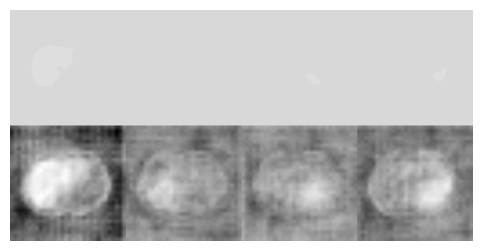

In [65]:
test(60)